In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from IPython.display import clear_output
import matplotlib.pyplot as plt
from numpy.random import RandomState

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return 1 / (np.exp(x)+np.exp(-x)+1)

def relu(x):
    return np.maximum(0,x)

def relu_derivative(x):
    return np.where(x>0,1,0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1-np.tanh(x)**2

In [3]:
# Xavier initialization function to not have weight too small that can cause instability
def xavier_init(size_in, size_out, random_state = None):
    rng = random_state
    limit = np.sqrt(6 / (size_in + size_out))
    return rng.uniform(-limit, limit, (size_in, size_out))

def Loading(tx):
    # clear_output(wait=True)
    Loadingbar = ''.join(["=" if (i < int(tx*100)) else " " for i in range(100)])
    print("[" + "\033[32m" +  Loadingbar +'\033[0m' + "]")

def Accuracy(Nw,X,Y):
    predictions = Nw.forward(X)
    return round(np.mean((Y -predictions)**2 <= (0.05)**2),2) + 0.01*round(np.mean((Y -predictions)**2 <= (0.02)**2),2) #, np.mean([round(Y[i],1)==round(predictions[i],1) for i in range(len(Y))])

In [4]:
class Activation_Function:
    
    def __init__(self,func,func_derivative, name = None):
        self.func = func
        self.derivative = func_derivative
        self.name = name 
        


class Layer:
    def __init__(self,in_size,out_size, random_state = None):
        rng = random_state if random_state else np.random #setting the random seed instance for stability and reproductibility
        
        self.weights = xavier_init(in_size, out_size, random_state = rng)#np.random.randn(in_size,out_size) #xavier_init(in_size, out_size)
        self.bias = np.zeros((1,out_size))
        #self.delta = np.zeros((19,1))

    def Calculate_error(self, out_weights,out_delta,activation_derivative):

        self.delta =  out_delta.dot(out_weights.T) * activation_derivative(self.output)
        return self.delta

    def Calculate_output_error(self,y,output,activation_derivative):
        ### Only use if the layer is the output layer (might do a separate func one day)
        self.delta = (y-output)*activation_derivative(output)
        return self.delta

    def update(self,error, inputs, learning_rate):
        self.weights += inputs.T.dot(error) * learning_rate
        self.bias += np.sum(self.delta, axis=0, keepdims=True) * learning_rate

    def forward(self, activation, X):
        self.inputs = np.dot(X,self.weights) + self.bias
        self.output = activation(self.inputs)
        return self.output


class Network:
    def __init__(self,input_size,hidden_size,output_size,Name = "Network", random_state = None,activation = Activation_Function(relu,relu_derivative)):
        self.name = Name
        self.random_state = random_state
        
        # Initializing layers
        self.hidden_layer = Layer(input_size,hidden_size, random_state = random_state)
        self.output_layer = Layer(hidden_size,output_size, random_state = random_state)      

        self.out_delta = self.hidden_delta = 0
    
        self.activation = activation
    

    def forward(self,X):
        self.hidden_layer.forward(self.activation.func,X)

        self.output_layer.forward(relu,self.hidden_layer.output)

        self.output = self.output_layer.output

        return self.output_layer.output
    
    def loss(self,y,output):
        return (y-output)#/(abs(y-output))#**0.5

    

    def learn(self,X,y,learning_rate,momentum):

        #Calculating error
        self.out_delta = self.output_layer.Calculate_output_error(y,self.output_layer.output,relu_derivative) + self.out_delta*momentum
        self.hidden_delta = self.hidden_layer.Calculate_error(self.output_layer.weights,self.output_layer.delta,self.activation.derivative) + self.hidden_delta*momentum

        # Update weights and biases

        self.output_layer.update(self.out_delta,self.hidden_layer.output,learning_rate)
        self.hidden_layer.update(self.hidden_delta,X,learning_rate)

    def train(self,X,y,epochs,learning_rate,momentum,train_steps = 100, Training_Info= True, random_state = None):
        History = []
        rng = random_state
        for epoch in range(epochs):
            
            self.forward(X)
            self.learn(X,y,learning_rate,momentum)

            loss = np.mean(np.square(y - self.output))
            History.append(loss)   

            if Training_Info and epoch % train_steps == 0 :
                
                clear_output(wait=True)
                print(f"Training {self.name} \n Epoch  : {epoch} / {epochs} \n Loss : {loss} \n Advancement : {epoch/epochs*100} %")
                Loading(epoch/epochs)

        if Training_Info:
            loss = np.mean(np.square(y - self.output))
            clear_output(wait=True)
            print(f"Training {self.name} \n Epoch  : {epochs} / {epochs} \n Loss : {loss} \n Advancement : {100} %")
            Loading(1)
        return History
        
            

# Simulation des courbes

In [5]:
Ke = 10**(-14)

def neutralitePolyAcide(pH,C,V0,Ct,Vt,pKa): 
    h = 10**(-pH)
    Ka = [10**(-pka) for pka in pKa]
    neutre = (h - Ke/h)*(V0 + Vt) + Ct*Vt
    for i in range(len(C)) :
        neutre = neutre - C[i]*V0/(1+h/Ka[i])
    return neutre

def calcul_pHPolyAcide(C,V0,Ct,Vt,pKa): 
    a = 0
    b = 14
    while b-a > 0.01 : 
        m = (a + b)/2
        if neutralitePolyAcide(a,C,V0,Ct,Vt,pKa)*neutralitePolyAcide(m,C,V0,Ct,Vt,pKa) <= 0 :
            b = m
        else :
            a = m
    return m

def titragePolyAcide(pKa, C, V0, Ct, Vmax, pas) :
    VSim = [] # tableau de valeur pour stocker les volumes
    PHSim = [] # tableau de valeur pour stocker les pH correspondants
    v = 0 # volume "courant"
    while v <= Vmax : 
        VSim.append(v)
        c = 10**(-calcul_pHPolyAcide(C, V0, Ct, v, pKa))
        PHSim.append(-np.log10(c*V0/(V0+v)))
        v = v + pas
    return VSim, PHSim

In [10]:
Concentrations = np.array([[float(a) for a in line.split()] for line in open('./Données expérimentales/Labels.txt')][4:])/100

In [11]:
pKas = [2.87,4.2,4.76, 5.48 ]

V0,Vmax,Ct,DV = 10,10,0.01,0.25

Visualisation

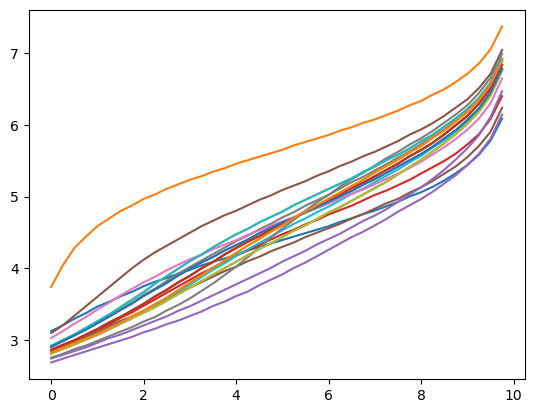

In [12]:
DATA = []

for cc in Concentrations : 
    X, Y = titragePolyAcide(pKas, cc, V0, Ct, Vmax, DV)
    DATA.append(Y)
    plt.plot(X[:-1],Y[:-1])
plt.show()

In [13]:
DATA = np.array(DATA)
LABELS = np.array(Concentrations)*100

pca = PCA(5)
pca.fit(DATA)
DataTrain = pca.transform(DATA)

#X_train,X_test,Y_train, Y_test = train_test_split(DataTrain/14, Labels, test_size=0.2)

X_train,X_test,Y_train, Y_test = train_test_split(DataTrain/max([max(DataTrain[:,i]) for i in range(DataTrain.shape[1])]), LABELS, test_size=0.2)

# ANN

## Initialisation

In [ ]:
Acides = ['acide_chloroacétique', 'acide_benzoique', 'acide_éthanoique', '4_aminophénol']

Models_val = [0 for i in Acides]

Histories = [None for i in Acides]

In [ ]:
Relu,Tan,Sig = Activation_Function(relu,relu_derivative,name='relu'),Activation_Function(tanh,tanh_derivative,name = 'tanh'),Activation_Function(sigmoid,sigmoid_derivative,name = 'sigmoid')

## Entraînement

In [ ]:
import numpy as np
from itertools import product

np.random.seed(42)


# Hyperparameter ranges
i_size,o_size = 5,1 
epoch_options =[8000]#[8000, 2000, 3000, 5000, 10000]# [8000, 10000,9000,7000]#, 30000], 35000, 40000]  # Possible values for epochs
learning_rate_options = [0.0001, 0.0005, 0.001, 0.005,0.00005,0.01]# 0.01, 0.05, 0.09, 0.1]  # Possible values for learning rates
momentum_options = [0.5,0.2, 0.4, 0.6, 0.8]  # Possible values for momentum
h_size_options = [3,4,5,6,7] #[6]
activation_options = [Tan,Sig,Relu]

N_iter =  len(h_size_options)*len(epoch_options)*len(learning_rate_options)*len(momentum_options)*len(activation_options)

# Store best parameters and scores for each acid
best_params = {}
best_scores = {}
Models = [0 for i in range(len(Acides))]
# Perform grid search for each acid
for i, acid in enumerate(Acides):
    print(f"\nTuning hyperparameters for acid: {acid}")
    
    best_params[acid] = None
    best_scores[acid] = -float('inf')#-float('inf')  # Use 'inf' because we are minimizing the loss
    #first = True
    # Grid search over all hyperparameter combinations
    iteration = 0
    for h_size, epochs, learning_rate, momentum,activation in product(h_size_options, epoch_options, learning_rate_options, momentum_options,activation_options):
        clear_output(wait=True)
        Loading(iteration/N_iter)
        print(f"Testing combination for {acid}: Epochs={epochs}, Learning Rate={learning_rate}, Momentum={momentum}, Activation={activation.name}")
        iteration+=1
        #if first:
        rng = RandomState(42)
        #else:
        #rng = np.random
        # Initialize and train the model for the current acid
        model = Network(input_size=i_size, output_size=o_size, hidden_size=h_size, Name=acid, random_state = rng,activation = activation)
        history = model.train(
            X_train,
            np.array([[Y_train[j][i]] for j in range(len(Y_train))]),
            epochs=epochs,
            learning_rate=learning_rate,
            momentum=momentum,
            Training_Info = False,
            train_steps=1000, 
            random_state = rng
        )
        """
        val_predictions = model.forward(X_test)
        val_loss = np.mean((np.array([[Y_test[j][i]] for j in range(len(Y_test))]) - val_predictions.T) ** 2)
        
        # Keep track of the best hyperparameters for this acid
        if val_loss < best_scores[acid]:
            best_scores[acid] = val_loss
            best_params[acid] = (epochs, learning_rate, momentum)
        """
        # Evaluate the model on the validation set
        current_accuracy = Accuracy(model,X_test,np.array([[Y_test[j][i]] for j in range(len(Y_test))]))
        
        
            # Keep track of the best hyperparameters for this acid
        if current_accuracy > best_scores[acid]:
            best_scores[acid] = current_accuracy
            best_params[acid] = (epochs, learning_rate, momentum, h_size,activation)
            Models[i] = model
            first = False
    print(f"Best Hyperparameters for {acid}: Epochs={best_params[acid][0]}, Learning Rate={best_params[acid][1]}, Momentum={best_params[acid][2]}, function={best_params[acid][4].name}")
    print(f"Best Validation Loss for {acid}: {best_scores[acid]:.4f}")
    
# Final results for all acids
print("\nFinal Best Hyperparameters for Each Acid:")
for acid in Acides:
    print(f"{acid}: Epochs={best_params[acid][0]}, Learning Rate={best_params[acid][1]}, Momentum={best_params[acid][2]}, Validation accuracy={best_scores[acid]:.4f}, h_size={best_params[acid][3]}, function={best_params[acid][4].name}")


[=================================================================================================== ]
Testing combination for 4_aminophénol: Epochs=8000, Learning Rate=0.01, Momentum=0.8, Activation=relu
Best Hyperparameters for 4_aminophénol: Epochs=8000, Learning Rate=0.01, Momentum=0.8, function=tanh
Best Validation Loss for 4_aminophénol: 1.0075

Final Best Hyperparameters for Each Acid:
acide_chloroacétique: Epochs=8000, Learning Rate=0.0001, Momentum=0.8, Validation accuracy=1.0100, h_size=5, function=relu
acide_benzoique: Epochs=8000, Learning Rate=0.005, Momentum=0.8, Validation accuracy=0.7575, h_size=6, function=relu
acide_éthanoique: Epochs=8000, Learning Rate=0.0005, Momentum=0.5, Validation accuracy=0.7575, h_size=3, function=tanh
4_aminophénol: Epochs=8000, Learning Rate=0.01, Momentum=0.8, Validation accuracy=1.0075, h_size=5, function=tanh


## Résultats

In [ ]:
for acid in Acides:
    print(f"{acid}: Epochs={best_params[acid][0]}, Learning Rate={best_params[acid][1]}, Momentum={best_params[acid][2]}, Validation accuracy={best_scores[acid]:.4f}")

acide_chloroacétique: Epochs=8000, Learning Rate=0.0001, Momentum=0.8, Validation accuracy=1.0100
acide_benzoique: Epochs=8000, Learning Rate=0.005, Momentum=0.8, Validation accuracy=0.7575
acide_éthanoique: Epochs=8000, Learning Rate=0.0005, Momentum=0.5, Validation accuracy=0.7575
4_aminophénol: Epochs=8000, Learning Rate=0.01, Momentum=0.8, Validation accuracy=1.0075


In [ ]:
predictions, = np.array([Nw.forward(X_test) for Nw in Models]).T  

i=0
for pred in predictions:
    print(str([round(pd,2) for pd in pred]) + "vs" + str(Y_test[i]))
    i +=1

[np.float64(0.1), np.float64(0.12), np.float64(0.38), np.float64(0.35)]vs[0.1 0.1 0.4 0.4]
[np.float64(0.29), np.float64(0.2), np.float64(0.19), np.float64(0.3)]vs[0.3 0.2 0.2 0.3]
[np.float64(0.26), np.float64(0.26), np.float64(0.28), np.float64(0.0)]vs[0.25 0.25 0.5  0.  ]
[np.float64(0.25), np.float64(0.3), np.float64(0.27), np.float64(0.0)]vs[0.25 0.5  0.25 0.  ]


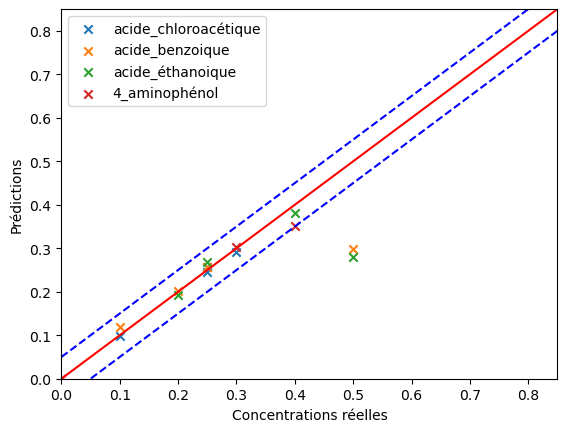

In [ ]:
for i in range(len(predictions.T)):
    plt.scatter(Y_test.T[i],predictions.T[i], marker='x',label = Acides[i])

x = np.linspace(0,1,100)

plt.plot(x,x, color = 'red')
plt.plot(x[2:],(x-0.05)[2:], '--b')
plt.plot(x,x+0.05, '--b')

plt.xlim(0,0.85)
plt.ylim(0,0.85)

plt.ylabel('Prédictions')
plt.xlabel('Concentrations réelles')

plt.legend()
plt.show()